
# Bagging Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html


+ basic sklearn calls
+ show that addition of a strong feature might degrade performance due to the trees geeting correlated


In [2]:
import numpy as np
import pylab as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from tqdm import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [34]:
Dp0=pd.read_csv('../datasets/S_MPOS_27_150',delimiter=" ",header=None)
Dn0=pd.read_csv('../datasets/S_MNEG_27_150',delimiter=" ",header=None)

Dp0s=Dp0
Dn0s=Dn0.sample(Dp0s.index.size)
Dn0s=Dn0.sample(2000)


D=pd.concat([Dp0s,Dn0s])
y=np.append(np.zeros([Dp0s.index.size,1]),np.ones([Dn0s.index.size,1]))

X=D.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

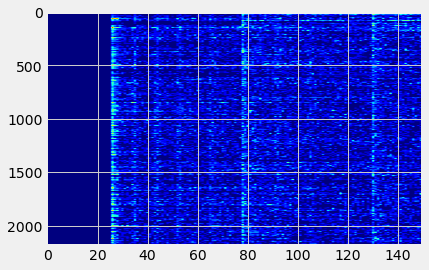

In [35]:
plt.imshow(X,aspect='auto',cmap='jet');

In [49]:
clf_ = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf_,n_estimators=1000,oob_score=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"% (y_test.shape[0],(y_test != y_pred).sum()))

acc=clf.score(X_test,y_test)
y_pred=clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
auc=metrics.auc(fpr, tpr)

print(acc,auc,clf.oob_score_)

Number of mislabeled points out of a total 1093 points : 112
0.8975297346752058 0.5811379657603224 0.9111721611721612


In [8]:
clf.estimators_[:5]

[DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=174961174),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=338988632),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1902345321),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1686560130),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1692509088)]

In [10]:
! pip3 install pydotplus --user -U

     |████████████████████████████████| 278 kB 3.0 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=04c2b8c76b151faf2113b77876481c16db24931f63ca9b5e7c3601c695396632
  Stored in directory: /home/ishanu/.cache/pip/wheels/89/e5/de/6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus


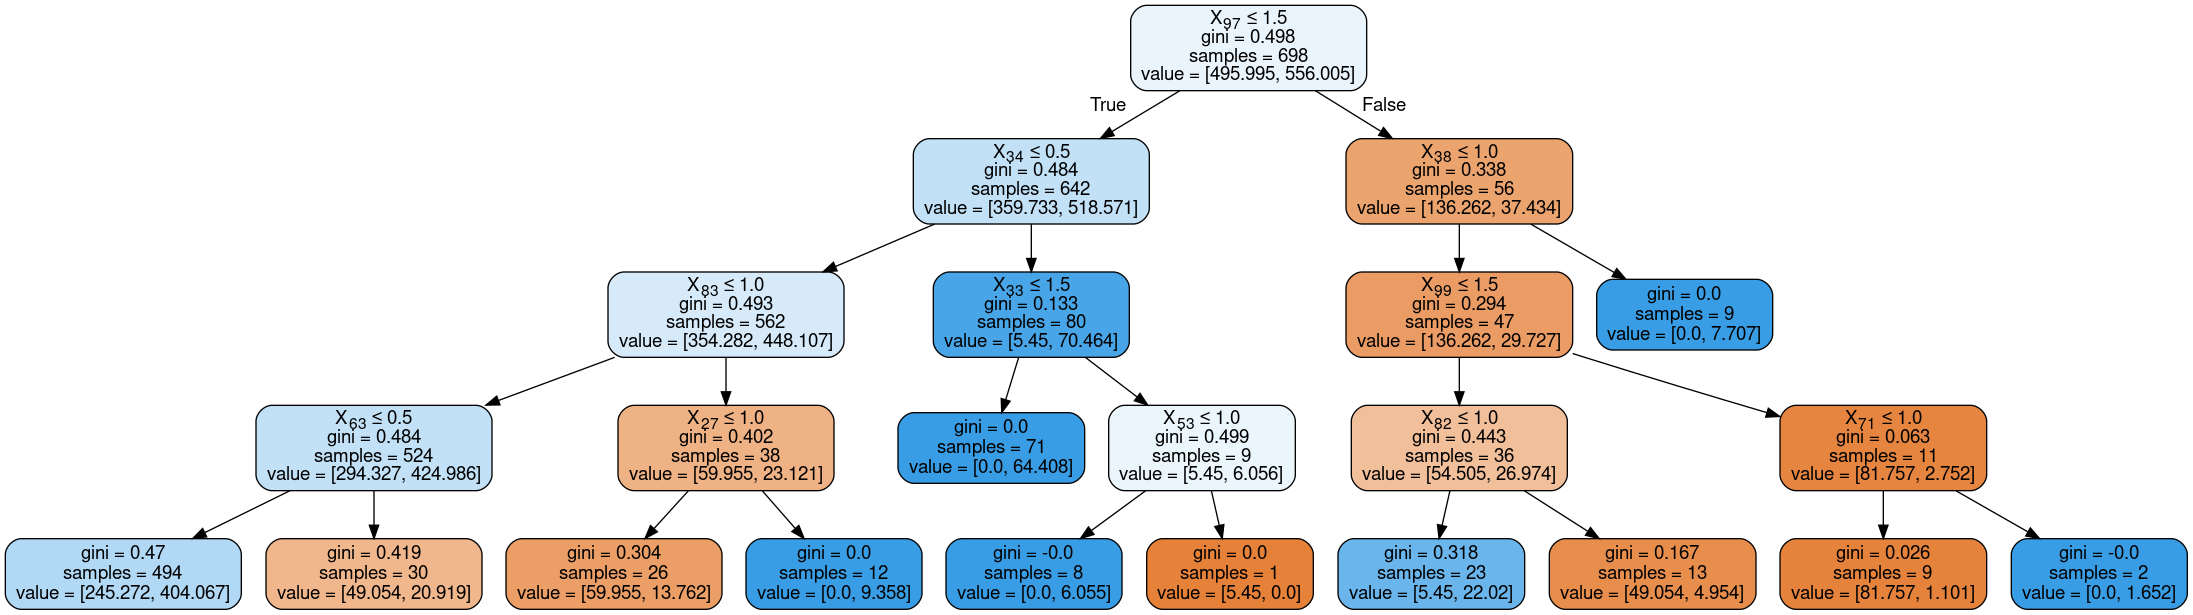

In [11]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

count=3
dot_data = StringIO()
export_graphviz(clf.estimators_[count], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
#export_graphviz(clf.estimators_[count], out_file='bagging_tree'+str(count)+'.dot',
#                filled=True, rounded=True,
#                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=1900, unconfined=True)

#call(['dot', '-Tpng', 'bagging_tree'+str(count)+'.dot', '-o', 'PSYtree'+str(count)+'.png', '-Gdpi=600'])

In [14]:
clf.estimators_[0].feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05909061, 0.        ,
       0.        , 0.1827589 , 0.14896269, 0.07905616, 0.        ,
       0.        , 0.05300165, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00987744,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03931115, 0.        , 0.        , 0.     

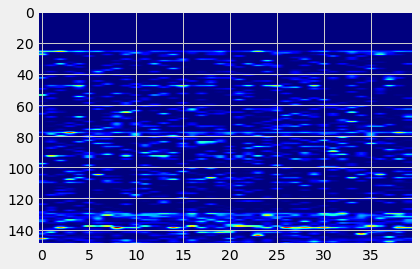

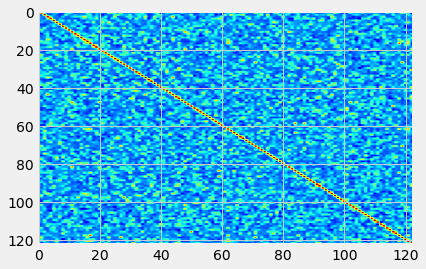

In [60]:
FI={}
count=0
for i in clf.estimators_:
    FI[count]=i.feature_importances_
    count=count+1
FI=pd.DataFrame(FI)
plt.imshow(FI.values,aspect='auto',cmap='jet');
cFI=np.corrcoef(FI.fillna(0).values+0.00001)
plt.figure()
plt.imshow(cFI[27:,27:],aspect='auto',cmap='jet');


In [61]:
# check how much the performance varies by random splits (variance)
RUNS=50
P=[]
for run in tqdm(np.arange(RUNS)):
    clf_ = DecisionTreeClassifier(max_depth=None, class_weight='balanced')
    clf = BaggingClassifier(base_estimator=clf_,n_estimators=40,oob_score=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    acc=clf.score(X_test,y_test)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    P=np.append(P,[acc,auc])
P=P.reshape(int(len(P)/2),2)

100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


0.5781650553877139

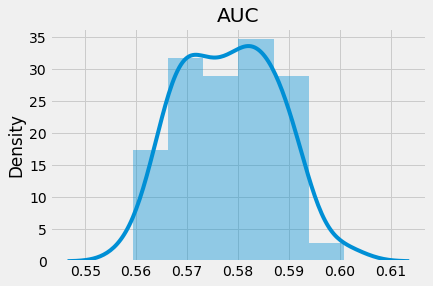

In [62]:
#auc
ax=sns.distplot(P[:,1])
ax.set_title('AUC')
P[:,1].mean()

Text(0.5, 1.0, 'accuracy')

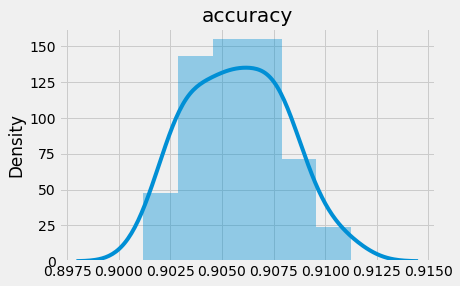

In [63]:
#acc
ax=sns.distplot(P[:,0])
ax.set_title('accuracy')

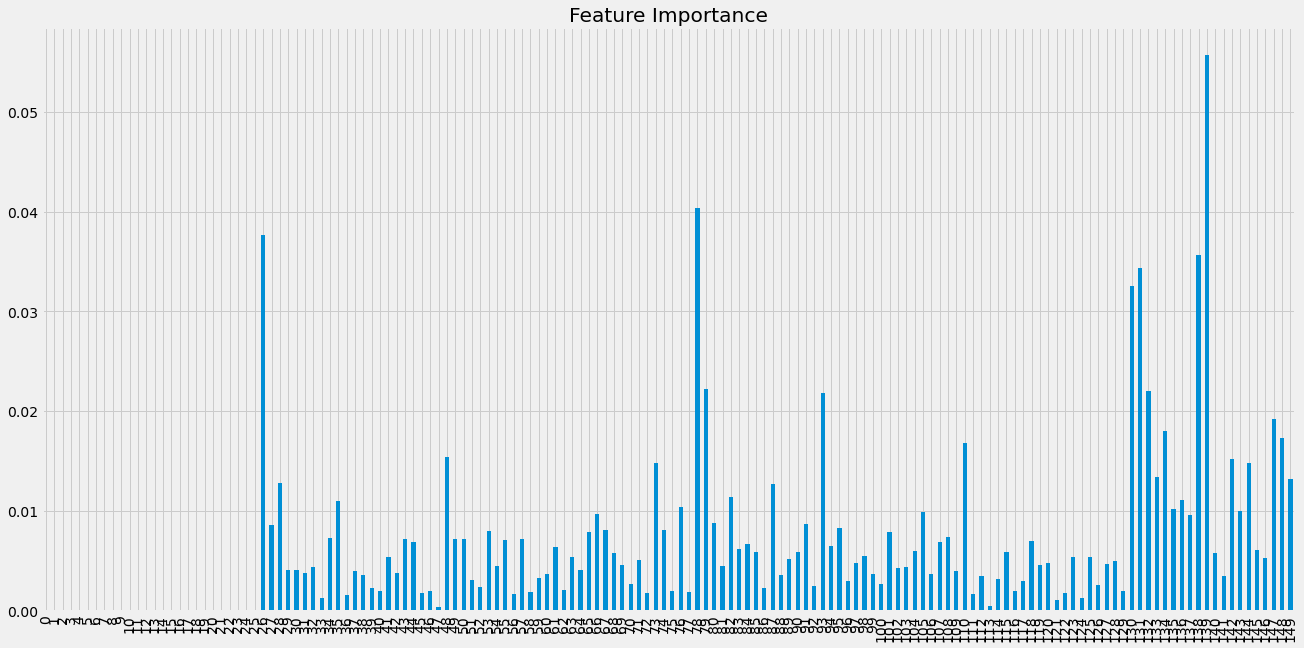

In [64]:
# compute feature importance
plt.figure(figsize=[20,10])
FI={}
count=0
for i in clf.estimators_:
    FI[count]=np.array(i.feature_importances_)
    count=count+1
#FI=FI/len(clf.estimators_)
ax=pd.DataFrame(FI).mean(axis=1).plot(kind='bar')
ax.set_title('Feature Importance');

# Investigate correlation problem in bagging classifiers

In [66]:
Dp0=pd.read_csv('../datasets/S_MPOS_27_150',delimiter=" ",header=None)
Dn0=pd.read_csv('../datasets/S_MNEG_27_150',delimiter=" ",header=None)

Dp0s=Dp0
Dn0s=Dn0.sample(Dp0s.index.size)
Dn0s=Dn0.sample(2000)


D=pd.concat([Dp0s,Dn0s])
y=np.append(np.zeros([Dp0s.index.size,1]),np.ones([Dn0s.index.size,1]))

# Add a strong feature

In [67]:
D['strong_feature']=np.random.normal(-.1, .1, y.shape)+y*.02

X=D.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [74]:
D

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,strong_feature
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,-0.074805
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.221382
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.234151
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.113999
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,2,-0.171348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,2,0,0.036404
4215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0.078963
8076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.167581
11472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.075125


In [71]:
clf_ = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf_,n_estimators=1000,oob_score=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"% (y_test.shape[0],(y_test != y_pred).sum()))

acc=clf.score(X_test,y_test)
y_pred=clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
auc=metrics.auc(fpr, tpr)

print(acc,auc,clf.oob_score_)

Number of mislabeled points out of a total 1093 points : 190
0.8261665141811528 0.640976933514247 0.8067765567765568


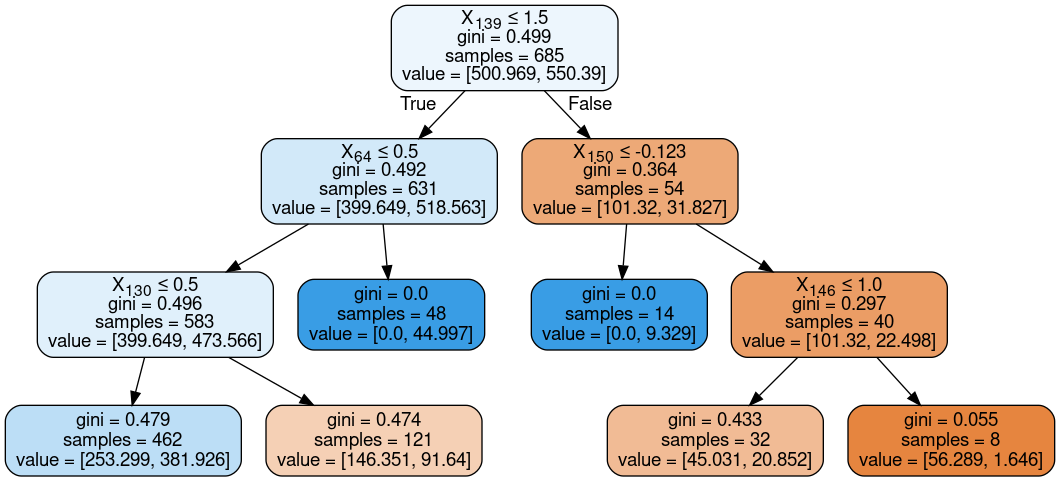

In [72]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

count=3
dot_data = StringIO()
export_graphviz(clf.estimators_[count], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
#export_graphviz(clf.estimators_[count], out_file='bagging_tree'+str(count)+'.dot',
#                filled=True, rounded=True,
#                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=1900, unconfined=True)

#call(['dot', '-Tpng', 'bagging_tree'+str(count)+'.dot', '-o', 'PSYtree'+str(count)+'.png', '-Gdpi=600'])


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.0,0.0,0.000000,0.067758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
147,0.0,0.0,0.065680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
148,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.111058,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0
149,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0


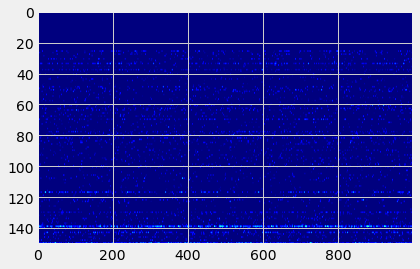

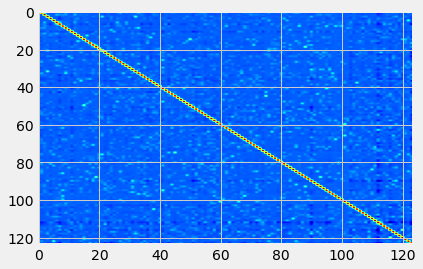

In [75]:
FI={}
count=0
for i in clf.estimators_:
    FI[count]=i.feature_importances_
    count=count+1
FI=pd.DataFrame(FI)
plt.imshow(FI.values,aspect='auto',cmap='jet');
cFI=np.corrcoef(FI.fillna(0).values+0.00001)
plt.figure()
plt.imshow(cFI[27:,27:],aspect='auto',cmap='jet');
FI

In [82]:
# check how much the performance varies by random splits (variance)
RUNS=50
P=[]
for run in tqdm(np.arange(RUNS)):
    clf_ = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
    clf = BaggingClassifier(base_estimator=clf_,n_estimators=40,oob_score=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    acc=clf.score(X_test,y_test)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    P=np.append(P,[acc,auc])
P=P.reshape(int(len(P)/2),2)

100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Text(0.5, 1.0, 'AUC')

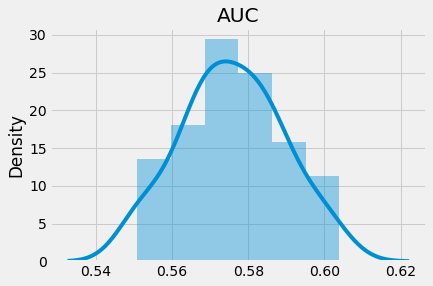

In [83]:
#auc
ax=sns.distplot(P[:,1])
ax.set_title('AUC')

Text(0.5, 1.0, 'accuracy')

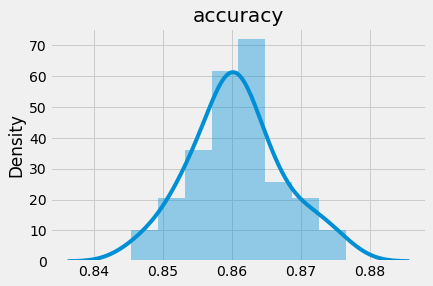

In [84]:
#acc
ax=sns.distplot(P[:,0])
ax.set_title('accuracy')

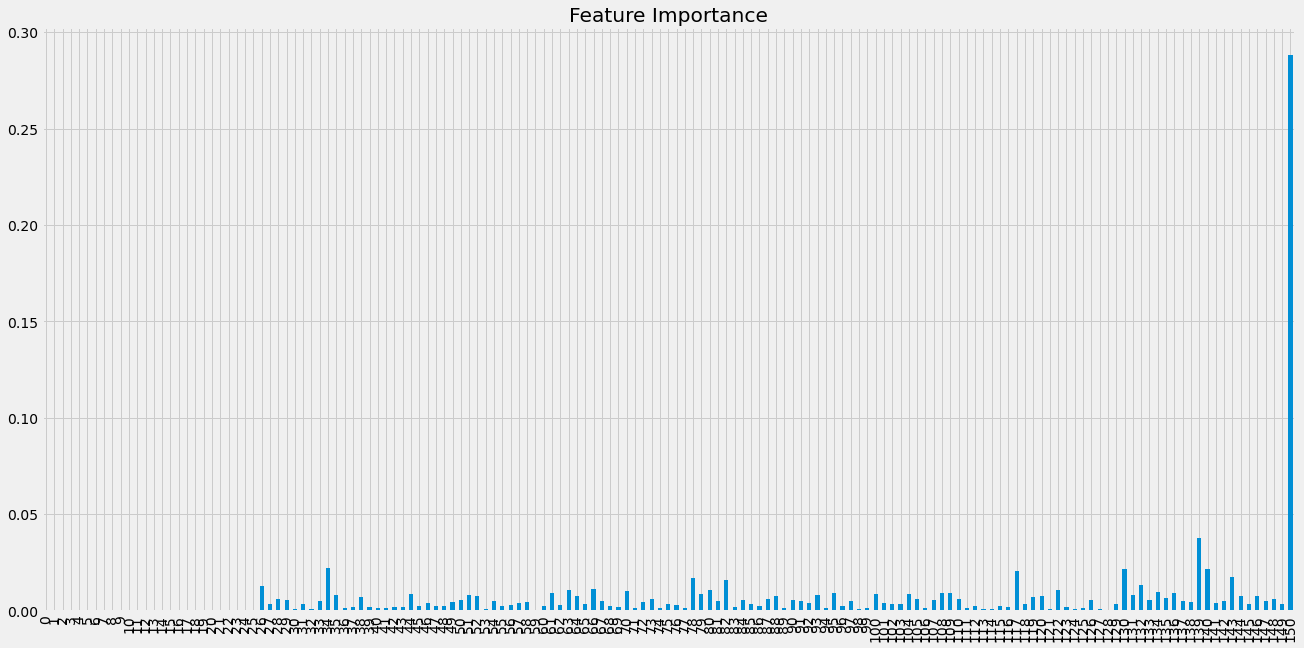

In [85]:
# compute feature importance
plt.figure(figsize=[20,10])
FI={}
count=0
for i in clf.estimators_:
    FI[count]=np.array(i.feature_importances_)
    count=count+1
#FI=FI/len(clf.estimators_)
ax=pd.DataFrame(FI).mean(axis=1).plot(kind='bar')
ax.set_title('Feature Importance');